In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shapefile
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

import folium
from folium.plugins import MarkerCluster

In [2]:
# Geocoding

from geopy.geocoders import Nominatim
from geopy.geocoders import Bing
from geopy.exc import GeocoderTimedOut

In [3]:
# Timestamp
from datetime import date

today = date.today() # date object
# Format
time_stamp = today.strftime("%m-%d-%Y")

# Loading the data

In [384]:
df = pd.read_csv('Raw Data/DOH COVID Data Drop_ 20200506 - 05 Case Information.csv')
df.tail()

,CaseCode,Age,AgeGroup,Sex,DateRepConf,DateDied,DateRecover,RemovalType,DateRepRem,Admitted,RegionRes,ProvRes,CityMunRes,RegionPSGC,ProvPSGC,CityMuniPSGC,HealthStatus,Quarantined
9999,C999677,35.0,35 to 39,Male,2020-04-22,NaN,NaN,NaN,NaN,NaN,NCR,For Validation,For Validation,PH130000000,NaN,NaN,Mild,NaN
10000,C999726,33.0,30 to 34,Male,2020-03-28,NaN,NaN,NaN,NaN,Yes,NCR,NCR,City Of Taguig,PH130000000,PH137600000,PH137607000,Mild,No
10001,C999732,54.0,50 to 54,Female,2020-04-27,NaN,NaN,NaN,NaN,NaN,NCR,For Validation,For Validation,PH130000000,NaN,NaN,Mild,NaN
10002,C999915,38.0,35 to 39,Male,2020-04-29,NaN,NaN,NaN,NaN,NaN,NCR,NCR,City of Manila,PH130000000,PH133900000,PH133900000,Mild,NaN
10003,C999918,50.0,50 to 54,Female,2020-04-13,NaN,NaN,NaN,NaN,NaN,NCR,NCR,City Of Mandaluyong,PH130000000,PH137400000,PH137401000,Mild,NaN


In [385]:
len(df)

10004

total cases in the country

# Cleaning

### Making date columns into datetime

In [386]:
df.DateRepConf =  pd.to_datetime(df.DateRepConf, format='%Y-%m-%d')
df.DateRecover =  pd.to_datetime(df.DateRecover, format='%Y-%m-%d')
df.DateRepRem =  pd.to_datetime(df.DateRepRem, format='%Y-%m-%d')
df.DateDied =  pd.to_datetime(df.DateDied, format='%Y-%m-%d')

In [387]:
df.ProvRes.unique()

array(['NCR', 'Laguna', 'Quezon', 'Cebu', 'For Validation', 'Pampanga',
       'Davao Del Sur', 'Bataan', 'Rizal', 'Palawan', 'Batangas',
       'Bulacan', 'Cavite', 'Antique', 'Zambales', 'Cagayan',
       'Misamis Oriental', 'Albay', 'Iloilo', 'Pangasinan', 'Benguet',
       'Zamboanga Del Sur', 'Negros Occidental', 'Isabela', 'Nueva Ecija',
       'Tarlac', 'Davao Del Norte', 'Samar (Western Samar)',
       'Camarines Sur', 'La Union', 'Oriental Mindoro', 'Abra',
       'Lanao Del Sur', 'Occidental Mindoro', 'Lanao Del Norte',
       'Marinduque', 'Nueva Vizcaya', 'Negros Oriental',
       'City Of Cotabato (Not A Province)', 'Agusan Del Norte', 'Ifugao',
       'Aklan', 'South Cotabato', 'Davao Oriental', 'Sultan Kudarat',
       'Cotabato (North Cotabato)', 'Misamis Occidental', 'Leyte',
       'Northern Samar', 'Bohol', 'Capiz', 'Ilocos Norte', 'Davao De Oro',
       'Camiguin', 'Davao Occidental', 'Ilocos Sur', 'Catanduanes',
       'Maguindanao', 'Bukidnon', 'Sulu', 'Romblon', 

### Changing Region names to match the shapefiles's region names

In [388]:
df.ProvRes.replace(to_replace ="City Of Cotabato (Not A Province)", value ="Maguindanao", inplace=True) 
df.ProvRes.replace(to_replace ="NCR", value ="Metropolitan Manila", inplace=True) 
df.ProvRes.replace(to_replace ="Cotabato (North Cotabato)", value ="North Cotabato", inplace=True) 
df.ProvRes.replace(to_replace ="Samar (Western Samar)", value ="Samar", inplace=True) 
df.ProvRes.replace(to_replace ="Davao Del Norte", value ="Davao del Norte", inplace=True) 
df.ProvRes.replace(to_replace ="Davao Del Sur", value ="Davao del Sur", inplace=True) 
df.ProvRes.replace(to_replace ="Lanao Del Norte", value ="Lanao del Norte", inplace=True) 
df.ProvRes.replace(to_replace ="Agusan Del Norte", value ="Agusan del Norte", inplace=True)
df.ProvRes.replace(to_replace ="Davao De Oro", value ="Davao de Oro", inplace=True)

In [389]:
df.CityMunRes.replace(to_replace ="Jala-Jala", value ="Jalajala", inplace=True) 

# Time series

### Number of cases per day

In [390]:
df_number_of_cases = pd.DataFrame(df.DateRepConf.value_counts())
df_number_of_cases.columns = ['new_cases']
df_number_of_cases.sort_index(inplace=True)
df_number_of_cases['total_cases'] = np.cumsum(df_number_of_cases.new_cases)
df_number_of_cases.tail()

,new_cases,total_cases
2020-05-02,156,8928
2020-05-03,295,9223
2020-05-04,262,9485
2020-05-05,199,9684
2020-05-06,320,10004


In [391]:
# sanity check

np.sum(df_number_of_cases.new_cases) #Total cases

10004

### Plot

<IPython.core.display.Javascript object>


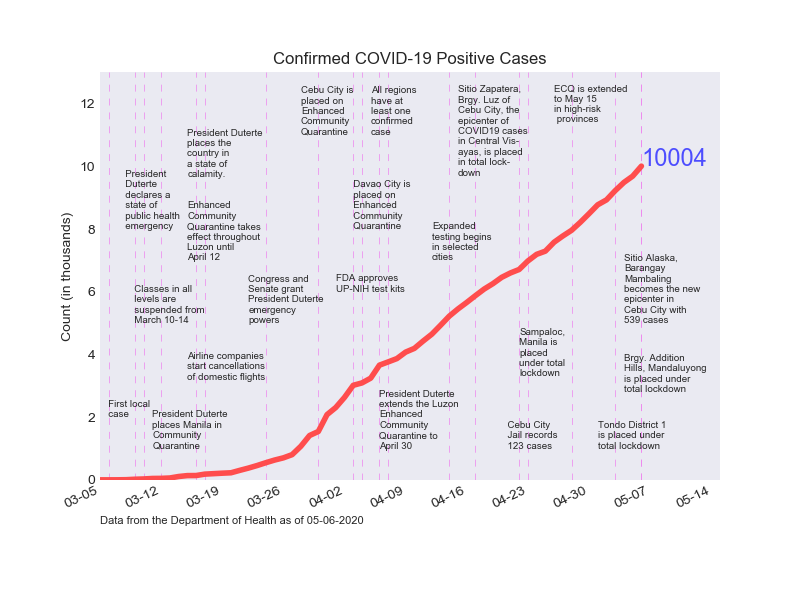

In [397]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
plt.title('Confirmed COVID-19 Positive Cases')

y_max = df_number_of_cases.iloc[-1].total_cases / 1000 + 3

# Story
ax.axvline(pd.to_datetime('2020-03-06'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-05'), 2, '   First local\n   case', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-9'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-07'), 8, '   President\n   Duterte\n   declares a\n   state of\n   public health\n   emergency', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-10'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-08'), 5, '   Classes in all\n   levels are\n   suspended from\n   March 10-14', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-12'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-11'), 1, 'President Duterte\nplaces Manila in\nCommunity\nQuarantine', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-16'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-15'), 7, 'President Duterte\nplaces the\ncountry in\na state of\ncalamity.\n\n\nEnhanced\nCommunity\nQuarantine takes\neffect throughout\nLuzon until\nApril 12', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-17'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-15'), 3.2, 'Airline companies\nstart cancellations\nof domestic flights', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-24'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-22'), 5, 'Congress and\nSenate grant\nPresident Duterte\nemergency\npowers', fontsize=7)

#ax.axvline(pd.to_datetime('2020-03-28'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
#ax.text(pd.to_datetime('2020-03-26'), 2.4, 'Number of\nconfirmed\npositive cases\nsurpass the\n1000-mark', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-30'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-28'), 11, 'Cebu City is\nplaced on\nEnhanced\nCommunity\nQuarantine', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-03'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-01'), 6, 'FDA approves\nUP-NIH test kits', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-04'), lw=.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-02'), 8, '   Davao City is\n   placed on\n   Enhanced\n   Community\n   Quarantine', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-06'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-05'), 11, 'All regions\nhave at\nleast one\nconfirmed\ncase', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-07'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-06'), 1, 'President Duterte\nextends the Luzon\nEnhanced\nCommunity\nQuarantine to\nApril 30', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-14'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-12'), 7, 'Expanded\ntesting begins\nin selected\ncities', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-17'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-15'),  9.7, 'Sitio Zapatera,\nBrgy. Luz of\nCebu City, the\nepicenter of\nCOVID19 cases\nin Central Vis-\nayas, is placed\nin total lock-\ndown', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-22'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-20'), 1, '  Cebu City\n  Jail records\n  123 cases', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-23'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-22'), 3.3, 'Sampaloc,\nManila is\nplaced\nunder total\nlockdown', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-28'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-26'), 11.4, 'ECQ is extended\nto May 15\nin high-risk\n provinces', fontsize=7)

ax.axvline(pd.to_datetime('2020-05-03'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-05-01'), 1, 'Tondo District 1\nis placed under\ntotal lockdown', fontsize=7)

ax.axvline(pd.to_datetime('2020-05-06'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-05-04'), 5, 'Sitio Alaska,\nBarangay\nMambaling\nbecomes the new\nepicenter in\nCebu City with\n539 cases', fontsize=7)

ax.axvline(pd.to_datetime('2020-05-06'), lw=0.5, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-05-04'), 2.8, 'Brgy. Addition\nHills, Mandaluyong\nis placed under\ntotal lockdown', fontsize=7)


# Designing
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))



# Plots
df_number_of_cases['total_cases'].copy().apply(lambda x: x / 1000).plot(ax=ax,
                                            label='Total', lw=4, color='#ff4d4d')##4da6ff
#plt.scatter(time_stamp, np.max(df_number_of_cases.total_cases)/1000, color='red', marker='o', s=1000)

ax.text(pd.to_datetime(time_stamp), np.max(df_number_of_cases.total_cases)/1000, 
        str(np.max(df_number_of_cases.total_cases)), color='#4d4dff', fontsize=17)




# ax.vlines(df_number_of_cases.index, ymin=0, ymax=df_number_of_cases.new_cases / 1000, 
#                                   lw=1.5, colors='#ff4d4d', label='New')

# ax.scatter(x=df_number_of_cases.index, y=df_number_of_cases.new_cases / 1000, 
#                                    color='#ff4d4d', marker='D', s=4)



plt.xlabel(' ')
plt.xlim(pd.to_datetime('2020-03-05'), pd.to_datetime('2020-05-15'))
plt.xticks(rotation=25)

plt.ylabel('Count (in thousands)')
plt.ylim(0, y_max)

#plt.legend(loc=2, frameon=True)
ax.text(pd.to_datetime('2020-03-05'), -1.4, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/total_cases', dpi=300, bbox_inches='tight')

### New cases only

<IPython.core.display.Javascript object>


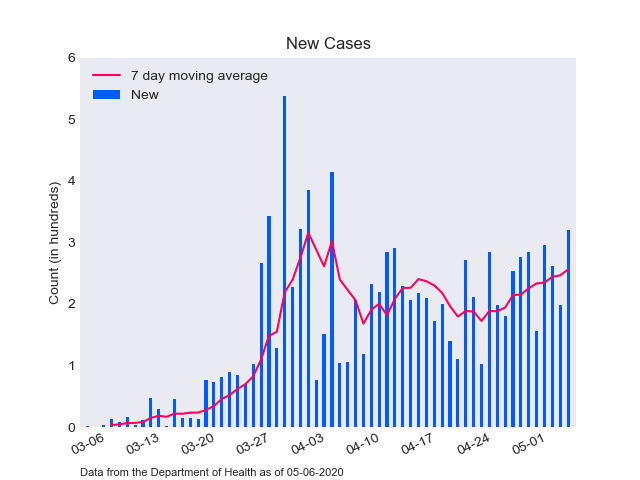

In [398]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

# Plots
ax.bar(df_number_of_cases.index, df_number_of_cases.new_cases / 100, width=0.4, color='#005aff', label="New") # 

# Moving average
ax.plot(df_number_of_cases.index, df_number_of_cases.new_cases.rolling(window=7).mean() / 100, 
        color="#ff005a", label="7 day moving average")

plt.xlim(pd.to_datetime('2020-03-05'), pd.to_datetime('2020-05-07'))
plt.ylim(0, 6)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.title('New Cases')
plt.xlabel(' ')
plt.ylabel('Count (in hundreds)')
plt.xticks(rotation=25)
plt.legend(loc=2)
ax.text(pd.to_datetime('2020-03-05'), -0.8, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/new_cases', dpi=300, bbox_inches='tight')

### Deaths and Recoveries

In [76]:
# Recoveries

df_number_of_recoveries = pd.DataFrame(df[df['RemovalType']=='Recovered'].DateRecover.value_counts())
df_number_of_recoveries.columns = ['new_recoveries']
df_number_of_recoveries.sort_index(inplace=True)
df_number_of_recoveries['total_recoveries'] = np.cumsum(df_number_of_recoveries.new_recoveries)
df_number_of_recoveries.tail()

,new_recoveries,total_recoveries
2020-05-01,5,780
2020-05-02,8,788
2020-05-03,3,791
2020-05-04,8,799
2020-05-05,6,805


In [77]:
# Deaths

df_number_of_deaths = pd.DataFrame(df[df['RemovalType']=='Died'].DateDied.value_counts())
df_number_of_deaths.columns = ['new_deaths']
df_number_of_deaths.sort_index(inplace=True)
df_number_of_deaths['total_deaths'] = np.cumsum(df_number_of_deaths.new_deaths)
df_number_of_deaths.head()

,new_deaths,total_deaths
2020-02-01,1,1
2020-03-11,3,4
2020-03-12,3,7
2020-03-13,4,11
2020-03-14,5,16


<IPython.core.display.Javascript object>


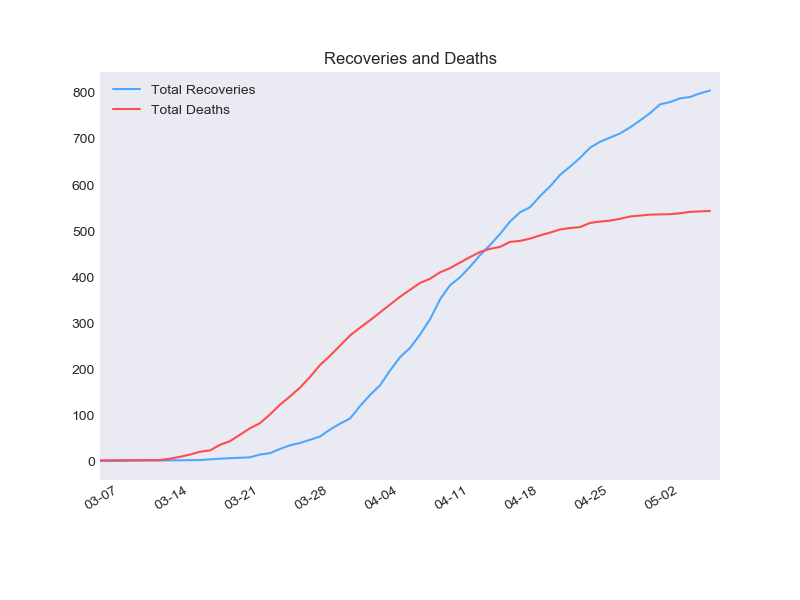

In [79]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
plt.title('Recoveries and Deaths')


df_number_of_recoveries['total_recoveries'].plot(ax=ax, label='Total Recoveries', lw=1.5, color='#4da6ff', ms=3.5)
df_number_of_deaths['total_deaths'].plot(ax=ax, label='Total Deaths', lw=1.5, color='#ff4d4d', ms=3.5)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.xlabel(' ')
plt.xlim(pd.to_datetime('2020-03-05'), time_stamp)

plt.legend()

# Dont save yet, incomplete

### Exponential Plot

<IPython.core.display.Javascript object>


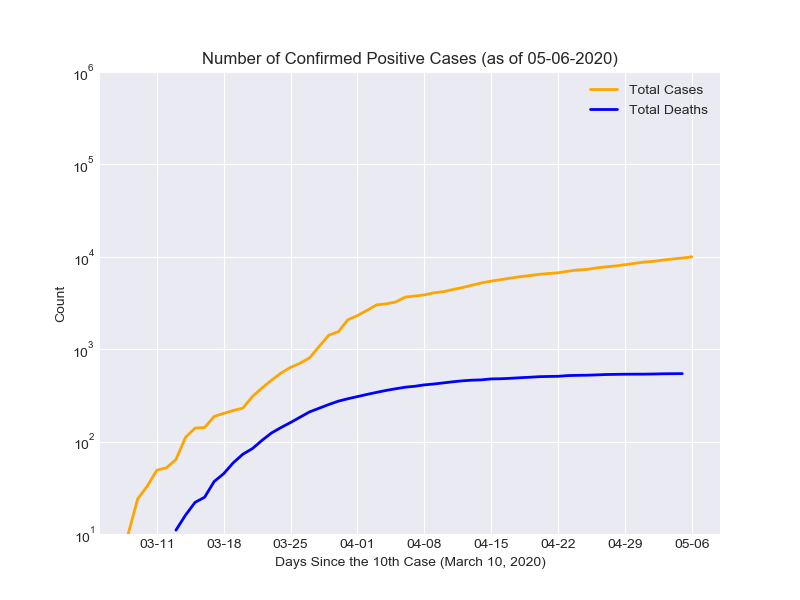

In [224]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

no_days_since_10th = np.array([i for i in range(0, len(df_number_of_cases['total_cases'][5:]))])
ax.plot(df_number_of_cases[5:].index, df_number_of_cases['total_cases'][5:], 
        lw=2, color='orange', label="Total Cases")
ax.plot(df_number_of_deaths[3:].index, df_number_of_deaths['total_deaths'][3:], 
        lw=2, color='blue', label="Total Deaths")

# Line that doubles everyday
#ax.plot(no_days_since_10th[:30], 1.2**no_days_since_10th[:30])

# Customization
plt.title('Number of Confirmed Positive Cases (as of {})'.format(time_stamp))
plt.xlabel('Days Since the 10th Case (March 10, 2020)')
plt.ylabel('Count')

ax.set_yscale('log')
plt.ylim((10^0, 10**6) )
#plt.xlim(0,75)
plt.grid(True)
plt.legend()

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


plt.savefig('images/exponential', dpi=300, bbox_inches='tight')

# Provinces

In [399]:
df.ProvRes.unique()

array(['Metropolitan Manila', 'Laguna', 'Quezon', 'Cebu',
       'For Validation', 'Pampanga', 'Davao del Sur', 'Bataan', 'Rizal',
       'Palawan', 'Batangas', 'Bulacan', 'Cavite', 'Antique', 'Zambales',
       'Cagayan', 'Misamis Oriental', 'Albay', 'Iloilo', 'Pangasinan',
       'Benguet', 'Zamboanga Del Sur', 'Negros Occidental', 'Isabela',
       'Nueva Ecija', 'Tarlac', 'Davao del Norte', 'Samar',
       'Camarines Sur', 'La Union', 'Oriental Mindoro', 'Abra',
       'Lanao Del Sur', 'Occidental Mindoro', 'Lanao del Norte',
       'Marinduque', 'Nueva Vizcaya', 'Negros Oriental', 'Maguindanao',
       'Agusan del Norte', 'Ifugao', 'Aklan', 'South Cotabato',
       'Davao Oriental', 'Sultan Kudarat', 'North Cotabato',
       'Misamis Occidental', 'Leyte', 'Northern Samar', 'Bohol', 'Capiz',
       'Ilocos Norte', 'Davao de Oro', 'Camiguin', 'Davao Occidental',
       'Ilocos Sur', 'Catanduanes', 'Bukidnon', 'Sulu', 'Romblon',
       'Guimaras'], dtype=object)

In [400]:
def province_counter(name):
    # 'Metropolitan Manila', Cebu, Etc
    df_prov = df[df.ProvRes==name].DateRepConf.value_counts().to_frame('counts')
    df_prov.sort_index(inplace=True)
    df_prov['total_cases'] = np.cumsum(df_prov.counts)
    return df_prov

<IPython.core.display.Javascript object>


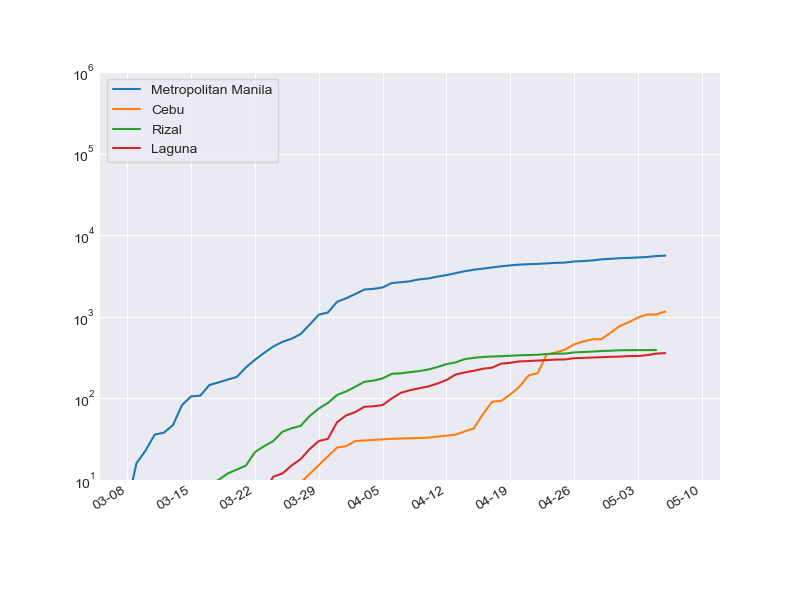

In [402]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

places = ["Metropolitan Manila", "Cebu", 'Rizal', 'Laguna']

for i in places:
    province_counter(i).total_cases.plot(label=i)
    
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax.set_yscale('log')
plt.xlim()
plt.ylim((10^0, 10**6) )
plt.grid(True)
plt.legend(loc=2, frameon=True)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


plt.xlim(pd.to_datetime('2020-03-05'), pd.to_datetime('2020-05-12'))
plt.savefig('images/provinces', dpi=300, bbox_inches='tight')


# Health Status

# Age Analysis

In [81]:
num_nan_ages = np.sum([pd.isna(i) for i in df.Age])
num_nan_ages

11

### Different bins

<IPython.core.display.Javascript object>


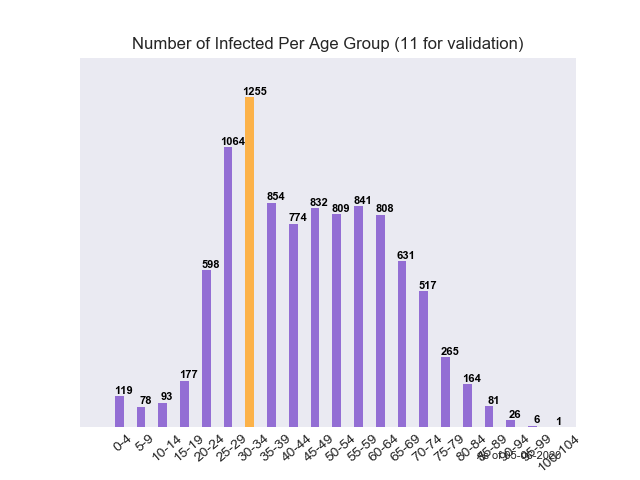

[Text(0, 0, '0-4'),
 Text(5, 0, '5-9'),
 Text(10, 0, '10-14'),
 Text(15, 0, '15-19'),
 Text(20, 0, '20-24'),
 Text(25, 0, '25-29'),
 Text(30, 0, '30-34'),
 Text(35, 0, '35-39'),
 Text(40, 0, '40-44'),
 Text(45, 0, '45-49'),
 Text(50, 0, '50-54'),
 Text(55, 0, '55-59'),
 Text(60, 0, '60-64'),
 Text(65, 0, '65-69'),
 Text(70, 0, '70-74'),
 Text(75, 0, '75-79'),
 Text(80, 0, '80-84'),
 Text(85, 0, '85-89'),
 Text(90, 0, '90-94'),
 Text(95, 0, '95-99'),
 Text(100, 0, '100-104')]

In [82]:
fig = plt.figure()

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

ax = plt.subplot(111)

bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105])
n, bins, patches = ax.hist(df.Age, bins, histtype='bar', color='#936ED4',rwidth=0.8, width=2, align='left')
patches[np.argmax(n)].set_fc('#FCB249')

# label each bar with each count
for index, bin_ in enumerate(bins):
    if bin_== 105:
        break
    ax.text(bin_, n[index] + 20, int(n[index]), 
            color='black', fontweight='bold',
            horizontalalignment='center', verticalalignment='center', fontsize=8)
    
if num_nan_ages==0:
    ax.set_title('Number of Infected Per Age Group')
    
if num_nan_ages>0:
    ax.set_title('Number of Infected Per Age Group ({} for validation)'.format(num_nan_ages))
    
# xtick labels
plt.xticks(bins)
ax.set_xlim(-10,104)
ax.set_ylim(0,np.max(n)+150)
    
# Removing spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Removing yticks
ax.get_yaxis().set_visible(False)

# Removing ticks
ax.tick_params(axis=u'both', which=u'both',length=0)

# Time stamp
ax.text(81, -120, 'As of {}'.format(time_stamp), fontsize=8)


# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_xticklabels()])
new_labels = []
for i in range(0,len(labels)-1):
    new_labels.append(labels[i] + '-' + str(int(labels[i+1])-1))
    
ax.set_xticklabels(new_labels, rotation=40)

In [83]:
# Sanity check

np.sum(n) + num_nan_ages

10004.0

total cases

### Horizontal bar graph

<IPython.core.display.Javascript object>


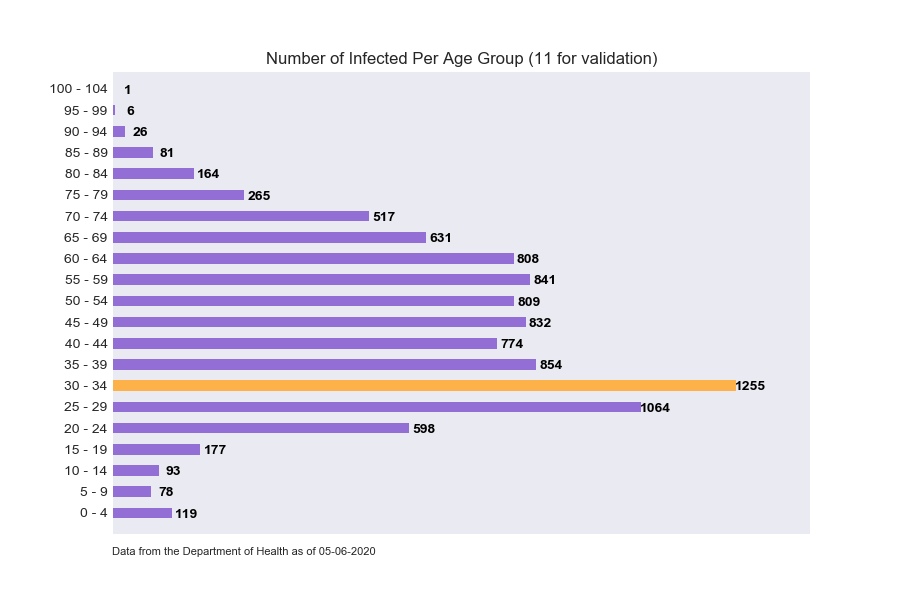

In [85]:
fig = plt.figure(figsize=(9,6))

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
ax = plt.subplot(111)

if num_nan_ages==0:
    ax.set_title('Number of Infected Per Age Group')
    
if num_nan_ages>0:
    ax.set_title('Number of Infected Per Age Group ({} for validation)'.format(num_nan_ages))


bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105])
n, bins, patches = ax.hist(df.Age, bins, histtype='bar', orientation="horizontal",
                           color='#936ED4', rwidth=0.5,  align='left')#,width=2 ,
patches[np.argmax(n)].set_fc('#FCB249')


# label each bar with each count
for index, bin_ in enumerate(bins):
    if bin_== 105:
        break
        
    ax.text(n[index] +30, bin_-0.4, int(n[index]), 
            color='black', fontweight='bold',
            horizontalalignment='center', verticalalignment='center', fontsize=10)
    
    
plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+150)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)

plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+150)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)

# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_yticklabels()])
new_labels = []
for i in range(0,len(labels)-1):
    new_labels.append(labels[i] + ' - ' + str(int(labels[i+1])-1))
    
ax.set_yticklabels(new_labels)

# Timestamp and source
ax.text(0, -10, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/num_infected', dpi=300, bbox_inches='tight')

### Deaths

<IPython.core.display.Javascript object>


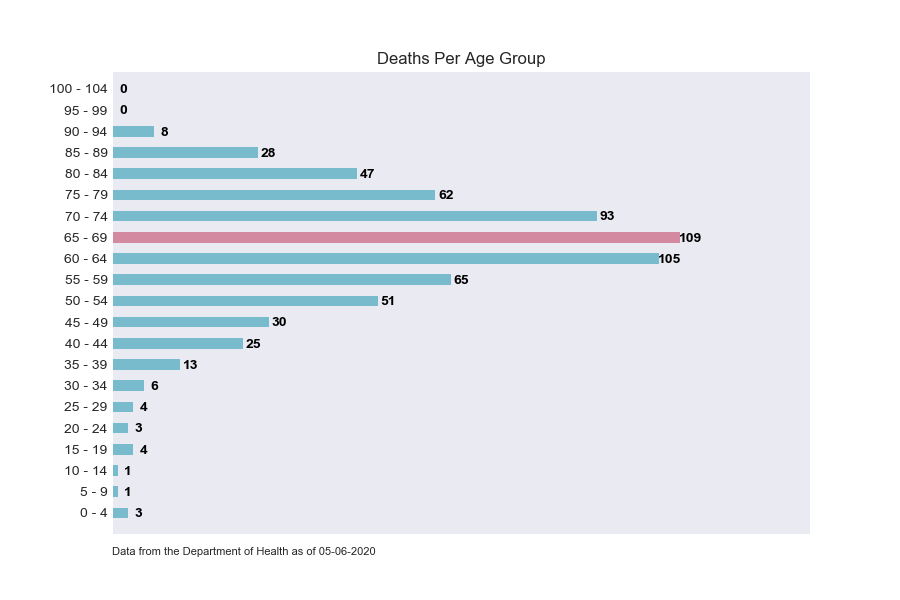

In [86]:
fig = plt.figure(figsize=(9,6))

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
ax = plt.subplot(111)

ax.set_title('Deaths Per Age Group')

bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105])
n, bins, patches = ax.hist(df[df.RemovalType=='Died'].Age, bins, histtype='bar', orientation="horizontal",
                           color='#77bbcc', rwidth=0.5,  align='left')#,width=2 ,#8ac4d3
patches[np.argmax(n)].set_fc('#d38aa0')


# label each bar with each count
for index, bin_ in enumerate(bins):
    if bin_== 105:
        break
        
    ax.text(n[index]+2, bin_-0.3, int(n[index]), 
            color='black', fontweight='bold',
            horizontalalignment='center', verticalalignment='center', fontsize=10)
    
plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)

plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+25)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)


# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_yticklabels()])
new_labels = []
for i in range(0,len(labels)-1):
    new_labels.append(labels[i] + ' - ' + str(int(labels[i+1])-1))
    
ax.set_yticklabels(new_labels)

# Timestamp and source
ax.text(0, -10, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/death_age_gp', dpi=300, bbox_inches='tight')

In [87]:
np.sum(n)

658.0

deaths

### Recoveries

<IPython.core.display.Javascript object>


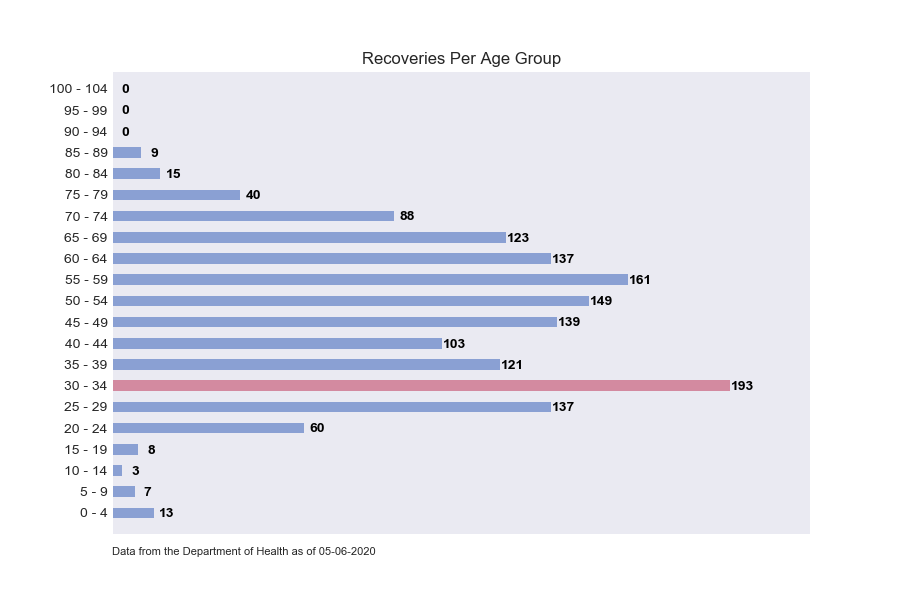

In [90]:
fig = plt.figure(figsize=(9,6))

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
ax = plt.subplot(111)

ax.set_title('Recoveries Per Age Group')

bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105])
n, bins, patches = ax.hist(df[df.RemovalType=='Recovered'].Age, bins, histtype='bar', orientation="horizontal",
                           color='#8aa0d3', rwidth=0.5,  align='left')#,width=2 ,
patches[np.argmax(n)].set_fc('#d38aa0')


# label each bar with each count
for index, bin_ in enumerate(bins):
    if bin_== 105:
        break
        
    ax.text(n[index]+4, bin_-0.3, int(n[index]), 
            color='black', fontweight='bold',
            horizontalalignment='center', verticalalignment='center', fontsize=10)
    
plt.yticks(bins)
ax.set_ylim(-5,89)
ax.set_xlim(0,np.max(n)+1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)

plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+25)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)


# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_yticklabels()])
new_labels = []
for i in range(0,len(labels)-1):
    new_labels.append(labels[i] + ' - ' + str(int(labels[i+1])-1))
    
ax.set_yticklabels(new_labels)

# Timestamp and source
ax.text(0, -10, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/recoveries_age_gp', dpi=300, bbox_inches='tight')

In [91]:
np.sum(n)

1506.0

number of recoveries

# Mapping the provinces with cases

In [372]:
df.ProvRes.unique()

array(['Metropolitan Manila', 'Laguna', 'Quezon', 'Cebu',
       'For Validation', 'Pampanga', 'Davao Del Sur', 'Bataan', 'Rizal',
       'Palawan', 'Batangas', 'Bulacan', 'Cavite', 'Antique', 'Zambales',
       'Cagayan', 'Misamis Oriental', 'Albay', 'Iloilo', 'Pangasinan',
       'Benguet', 'Zamboanga Del Sur', 'Negros Occidental', 'Isabela',
       'Nueva Ecija', 'Tarlac', 'Davao Del Norte', 'Samar',
       'Camarines Sur', 'La Union', 'Oriental Mindoro', 'Abra',
       'Lanao Del Sur', 'Occidental Mindoro', 'Lanao Del Norte',
       'Marinduque', 'Nueva Vizcaya', 'Negros Oriental', 'Maguindanao',
       'Agusan Del Norte', 'Ifugao', 'Aklan', 'South Cotabato',
       'Davao Oriental', 'Sultan Kudarat', 'North Cotabato',
       'Misamis Occidental', 'Leyte', 'Northern Samar', 'Bohol', 'Capiz',
       'Ilocos Norte', 'Davao De Oro', 'Camiguin', 'Davao Occidental',
       'Ilocos Sur', 'Catanduanes', 'Bukidnon', 'Sulu', 'Romblon',
       'Guimaras'], dtype=object)

In [405]:
df_regions = pd.DataFrame(df.ProvRes[pd.notnull(df.ProvRes)][df.ProvRes!="For Validation"].value_counts())
df_regions.columns = ['counts']
df_regions['Province'] = df_regions.index

# Repositioning the columns 
df_regions = df_regions[['Province', 'counts']]

# Changing the indices to a list of numbers
df_regions.index = [i for i in range(0, len(df_regions))]
df_regions[:10]

,Province,counts
0,Metropolitan Manila,5618
1,Cebu,1162
2,Rizal,392
3,Laguna,359
4,Cavite,283
5,Davao del Sur,138
6,Bulacan,125
7,Batangas,109
8,Bataan,81
9,Pampanga,67


In [406]:
# Sanity check, the only ones with no TBA cells

np.sum(df_regions.counts)

8928

In [407]:
# Getting the number of for validation cells

num_prov_TBA = len(df) - np.sum(df_regions.counts)
num_prov_TBA

1076

In [408]:
# Loading the shapefile
phl1 = shapefile.Reader("Shapefiles/gadm36_PHL_1") 

<IPython.core.display.Javascript object>


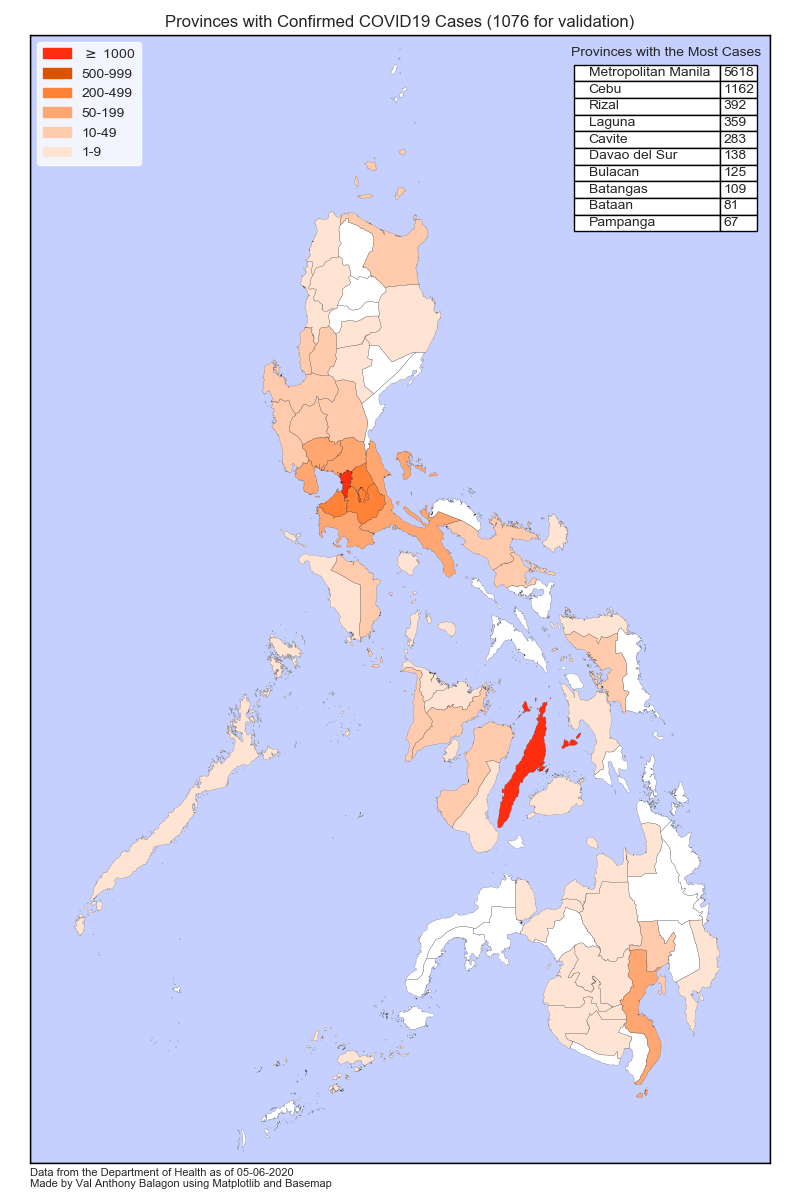

C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [412]:
fig, ax = plt.subplots(figsize=(8,12))

m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.8, urcrnrlat=21.1, resolution='l',
                projection='tmerc', lat_0 = 14, lon_0 = 120) 

if num_prov_TBA == 0:
    plt.title('Provinces with Confirmed COVID19 Cases')
if num_prov_TBA > 0 :
    plt.title('Provinces with Confirmed COVID19 Cases ({} for validation)'.format(num_prov_TBA))

# Make sure that the lakes do not get filled
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = False)


# Color each province
ls_provs = np.unique([ m.shf_info[i]['NAME_1'] for i in range(0, len(m.shf_info))])
patches=[]
for info, shape in zip(m.shf_info, m.shf):
    for i in ls_provs:
        if info['NAME_1'] == i:
            patches.append( Polygon(np.array(shape), True) )
ax.add_collection(PatchCollection(patches, 
                                  facecolor='white', linewidths=0.1, zorder=2))

# Coloring the province
def province_color(condition):
    patches=[]
    for info, shape in zip(m.shf_info, m.shf):
        for i in list(df_regions[condition].Province):
            if info['NAME_1'] == i:
                patches.append( Polygon(np.array(shape), True) )
    return patches

# 1-10
ax.add_collection(PatchCollection(province_color((df_regions.counts<10) & (df_regions.counts>=1)), 
                                  facecolor='#ffe4d3', linewidths=0.1, zorder=2))
# 10-50
ax.add_collection(PatchCollection(province_color((df_regions.counts<50) & (df_regions.counts>=10)), 
                                  facecolor='#ffcbac', linewidths=0.1, zorder=2))
# 50-200
ax.add_collection(PatchCollection(province_color((df_regions.counts<200) & (df_regions.counts>=50)), 
                                  facecolor='#ffa671', linewidths=0.1, zorder=2))
# 200-500
ax.add_collection(PatchCollection(province_color((df_regions.counts<500) & (df_regions.counts>=200)), 
                                  facecolor='#ff8236', linewidths=0.1, zorder=2))
# 500-1000
ax.add_collection(PatchCollection(province_color((df_regions.counts<1000) & (df_regions.counts>=500)), 
                                  facecolor='#db5200', linewidths=0.1, zorder=2))
# greater than 1000
ax.add_collection(PatchCollection(province_color((df_regions.counts>=1000)), 
                                  facecolor='#ff2d0f', linewidths=0.1, zorder=2))
# Legend
more_1000 = mpatches.Patch(color='#ff2d0f', label=r'$\geq$ 1000')
less_1000 = mpatches.Patch(color='#db5200', label=r'500-999')
less_500 = mpatches.Patch(color='#ff8236', label=r'200-499')
less_200 = mpatches.Patch(color='#ffa671', label=r'50-199')
less_50 = mpatches.Patch(color='#ffcbac', label=r'10-49')
less_10 = mpatches.Patch(color='#ffe4d3', label=r'1-9')
leg = plt.legend(loc=2, handles=[less_10, less_50, less_200, less_500, less_1000, more_1000][::-1], frameon=True)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')

m.drawmapboundary(fill_color='#c5d0fe')
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = True)

## Making another axis to make an inset
left, bottom, width, height = [0.75, 0.75, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_title('Provinces with the Most Cases', fontsize=10,x=0.41, y=.98)

## Making the table
top_10_prov_ls = np.array((df_regions.Province[:10]))[np.newaxis].T
top_10_prov_count = np.array((df_regions.counts[:10]))[np.newaxis].T
table = ax2.table(cellText=np.hstack((top_10_prov_ls, top_10_prov_count)),
                  colWidths = [0.2]*100,
                  loc='upper right',
                  fontsize=10,
                  cellLoc='left',
                  edges='closed')
table.auto_set_column_width(col=list(range(len(df_regions))))
ax2.axis("off")
ax2.axis('tight')


ax.text(0, -40000, 'Data from the Department of Health as of {}\nMade by Val Anthony Balagon using Matplotlib and Basemap'.format(time_stamp), fontsize=8)
fig.tight_layout()

In [413]:
plt.savefig('images/provinces_w_cases', dpi=800, bbox_inches='tight')

In [414]:
len(df_regions)

60

 out of 81 provinces have at least 1 confirmed positive COVID-19 case

### Locations of each case

In [109]:
df_locs = df[(df.CityMunRes!="For Validation") & (df.CityMunRes!="For Validation") & (df.ProvRes.notnull()) & (df.CityMunRes.notnull())][['CaseCode', 'ProvRes', 'CityMunRes']].copy()

# Replacing Metropolitan Manila to Metro Manila
df_locs.ProvRes.replace(to_replace='Metropolitan Manila', value='Metro Manila', inplace=True)

# Removes parenthesis in cities 
def remove_parenthesis(text):
    if '(' in text:
        return re.findall('(.+) \(.+\)', text)[0]
    else:
        return text
    
# Removes "City of"
def remove_cityof(txt):
    if 'City Of' in txt:
        return re.findall('City Of (.+)', txt)[0]
    if 'City of' in txt:
        return re.findall('City of (.+)', txt)[0]
    else:
        return txt
    
# Updates the Province column and removes (former name) and City of    
df_locs.CityMunRes = df_locs.CityMunRes.apply(remove_parenthesis).apply(remove_cityof)

# Combining the city and province string for geocoding
df_locs['comp_address'] = [df_locs.iloc[i].CityMunRes + ', ' + df_locs.iloc[i].ProvRes for i in range(0, len(df_locs))]

df_locs = pd.DataFrame(df_locs.comp_address.value_counts())
df_locs.columns = ['counts']
df_locs['com_address'] = df_locs.index
df_locs.index = [i for i in range(0, len(df_locs))]
df_locs = df_locs[['com_address', 'counts']]
df_locs.head()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(df_locs)

,com_address,counts
0,"Quezon City, Metro Manila",1457
1,"Cebu, Cebu",1014
2,"Manila, Metro Manila",749
3,"Parañaque, Metro Manila",499
4,"Makati, Metro Manila",472


In [110]:
# Reading the cached coordinates

locs_cached = pd.read_csv('Raw Data/cities_municipalities_coordinates.csv', encoding='latin-1')

# Makes the coordinates column into a tuple instead of a string
locs_cached.coordinates = locs_cached.coordinates.apply(eval)

In [111]:
# Geocoder with cached scanning

geolocator = Bing('AsCIIUyQuVTJ4Df_KgfhNFOzKq2G18CNh2pKyXuDIfD7BReMtoz9COVbWsqbi4Jh')

def do_geocode_Bing_cached(g):
    try:
        loc = geolocator.geocode(g)
        print(loc.address)
        return loc
    except GeocoderTimedOut:
        return do_geocode_Bing_cached(g)

In [112]:
df_locs.com_address

0      Quezon City, Metro Manila
1                     Cebu, Cebu
2           Manila, Metro Manila
3        Parañaque, Metro Manila
4           Makati, Metro Manila
                 ...            
370     Bayombong, Nueva Vizcaya
371                Lamut, Ifugao
372            Balagtas, Bulacan
373                 Catmon, Cebu
374               Lobo, Batangas
Name: com_address, Length: 375, dtype: object

In [113]:
# Geocoding 

coords = []

for x in df_locs.com_address:
    # Getting each string of each address
    
    
    # If the address already is in the cache, we just use the cache coordinates
    if x in np.array(locs_cached.com_address):
        print(x)
        coords.append(locs_cached.loc[locs_cached.com_address == x, 'coordinates'].values[0])
        continue
        
    # If not then we geocode
    else: 
        location = do_geocode_Bing_cached(x)
        coords.append((location.latitude, location.longitude))
        continue

Quezon City, Metro Manila
Cebu, Central Visayas, Philippines
Manila, Metro Manila
Parañaque, Metro Manila
Makati, Metro Manila
Mandaluyong, Metro Manila
Pasig, Metro Manila
Taguig, NCR, Philippines
San Juan, Metro Manila
Caloocan, NCR, Philippines
Pasay City, Metro Manila
Las Piñas, Metro Manila
Muntinlupa, Metro Manila
Davao, Davao Region, Philippines
Marikina, Metro Manila
Antipolo, Rizal
Valenzuela, Metro Manila
Bacoor, Calabarzon, Philippines
Cainta, Rizal
Mandaue, Central Visayas, Philippines
San Pedro, Laguna
Malabon, Metro Manila
Lapu-Lapu, Central Visayas, Philippines
Calamba, Laguna
Imus, Calabarzon, Philippines
Zamboanga, Zamboanga Peninsula, Philippines
Dasmariñas, Cavite
Lipa, Calabarzon, Philippines
Navotas, Metro Manila
Los Baños, Laguna
Taytay, Rizal
Binangonan, Rizal
Santa Rosa, Laguna
Biñan, Laguna
Balanga, Bataan
Baguio, Cordillera Administrative Region, Philippines
Rodriguez, Rizal
San Mateo, Rizal
Lucena, Calabarzon, Philippines
Pateros, Metro Manila
Santa Cruz, Lag

Bantayan, Central Visayas, Philippines
Pasacao, Camarines Sur
Magalang, Pampanga
Laoag, Ilocos Region, Philippines
Mawab, Davao Region, Philippines
Catbalogan, Eastern Visayas, Philippines
Enrique B. Magalona, Negros Occidental
Koronadal, South Cotabato
Victoria, Tarlac
Baggao, Cagayan
Bayombong, Nueva Vizcaya
Lamut, Ifugao
Balagtas, Bulacan
Catmon, Central Visayas, Philippines
Lobo, Batangas


In [114]:
df_locs['coordinates'] = coords #latitude, longitude
df_locs.head()

,com_address,counts,coordinates
0,"Quezon City, Metro Manila",1457,"(14.647660255432129, 121.05149841308594)"
1,"Cebu, Cebu",1014,"(10.311209678649902, 123.89234161376953)"
2,"Manila, Metro Manila",749,"(14.588640213012695, 120.98454284667969)"
3,"Parañaque, Metro Manila",499,"(14.471159934997559, 121.02198791503906)"
4,"Makati, Metro Manila",472,"(14.568719863891602, 121.0281982421875)"


# Caching the coordinates

In [115]:
# Making into a csv file
df_locs[['com_address', 'coordinates']].to_csv('Raw Data/cities_municipalities_coordinates.csv', index=False, encoding='latin-1')

### Map

In [116]:
# Number of tba

num_TBA_city = len(df) - np.sum(df_locs.counts)

In [117]:
lats = [df_locs.coordinates.iloc[i][0] for i in range(0, len(df_locs))]
longs = [df_locs.coordinates.iloc[i][1] for i in range(0, len(df_locs))]

<IPython.core.display.Javascript object>


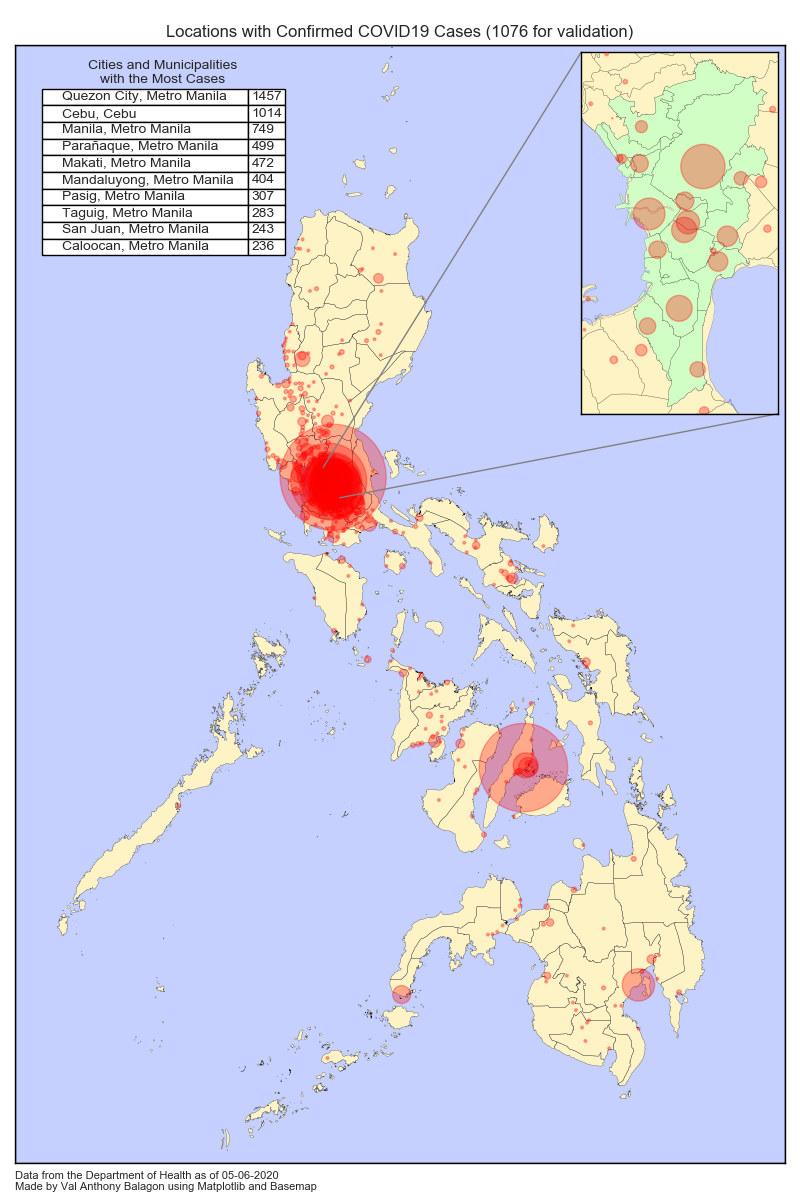

C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplo

Text(116.3, 4, 'Data from the Department of Health as of 05-06-2020\nMade by Val Anthony Balagon using Matplotlib and Basemap')

In [148]:
fig, ax = plt.subplots(figsize=(8,12))

if num_TBA_city == 0:
    plt.title('Locations with Confirmed COVID19 Cases')
if num_TBA_city > 0:
    plt.title('Locations with Confirmed COVID19 Cases ({} for validation)'.format(num_TBA_city))

m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.8, urcrnrlat=21.1, resolution='l',
            lat_0 = 14, lon_0 = 120) 
# Reading the shapefile
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = False)

# Make sure that the lakes do not get filled
m.drawmapboundary(fill_color='#c5d0fe')
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = False)


# Color each province
ls_provs = np.unique([ m.shf_info[i]['NAME_1'] for i in range(0, len(m.shf_info))])
patches=[]
for info, shape in zip(m.shf_info, m.shf):
    for i in ls_provs:
        if info['NAME_1'] == i:
            patches.append( Polygon(np.array(shape), True) )
ax.add_collection(PatchCollection(patches, 
                                  facecolor='#FEF3C5', linewidths=0.2, zorder=2))
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.15, drawbounds = True)

# Scatter Plot
x,y = m(longs, lats)
ax.scatter(x,y, c='red', edgecolors='red', alpha=.3, s=df_locs.counts*4, zorder=10)

# Table
left, bottom, width, height = [0.16, 0.73, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_title('Cities and Municipalities\nwith the Most Cases', fontsize=10,x=0.215, y=.97)

## Making the table
top_10_cities_ls = np.array((df_locs.com_address[:10]))[np.newaxis].T
top_10_cities_count = np.array((df_locs.counts[:10]))[np.newaxis].T
table = ax2.table(cellText=np.hstack((top_10_cities_ls, top_10_cities_count)),
                  colWidths = [0.2]*100,
                  loc='upper right',
                  fontsize=10,
                  cellLoc='left',
                  edges='closed')
table.auto_set_column_width(col=list(range(len(df_locs))))
ax2.axis("off")
ax2.axis('tight')


#Inset
axins = zoomed_inset_axes(ax, 12, loc=1)
m2 = Basemap(llcrnrlon=120.9, llcrnrlat=14.34, urcrnrlon=121.145, urcrnrlat=14.79, 
             resolution='f', lat_0 = 14.34, lon_0 = 121, ax=axins) 
m2.drawmapboundary(fill_color='#c5d0fe')
m2.fillcontinents(color='#FEF3C5', lake_color='#c5d0fe')
m2.drawcoastlines(linewidth=0.1)
m2.readshapefile('Shapefiles/gadm36_PHL_2', 'shf', linewidth=0.1,  drawbounds=False)

# Highlight Manila
patches = []
for info, shape in zip(m2.shf_info, m2.shf):
    if info['NAME_1'] == 'Metropolitan Manila':
        patches.append(Polygon(np.array(shape), True))        
axins.add_collection(PatchCollection(patches, facecolor='#d0fec5', linewidths=0.1, zorder=2))
m2.readshapefile('Shapefiles/gadm36_PHL_2', 'shf', linewidth=0.1,  drawbounds=True)

x_ins, y_ins = m(longs, lats)
axins.scatter(x_ins, y_ins, c='red', alpha=.3, s=df_locs.counts * 0.7, edgecolors='red', zorder=10)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

fig.tight_layout()
ax.text(116.3, 4, 'Data from the Department of Health as of {}\nMade by Val Anthony Balagon using Matplotlib and Basemap'.format(time_stamp), fontsize=8)

In [149]:
plt.savefig('images/map_of_cases', dpi=800, bbox_inches='tight')

# Folium

In [120]:
m = folium.Map(location=[np.mean(lats), np.mean(longs)], 
               tiles='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png',
                attr="Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.", 
               zoom_start=5.5)

# Location is in lat, long
for i in range(0, len(df_locs)):
    folium.Circle(location = list(df_locs.coordinates.iloc[i]),
          popup= folium.Popup(df_locs.com_address.iloc[i] + r'<br>Count: {}'.format(df_locs.counts.iloc[i]), 
                     encoding = 'latin-1',
                     max_height=100, min_height=100, 
                     max_width=250,min_width=130),
          radius=2000,
          color='red',
          fill=True,
          fill_color='red'
       ).add_to(m) #int(df_locs.counts.iloc[i])*100
m

In [121]:
m.save('images/cases_interactive.html')

# Testing Sites

In [193]:
df_testing_sites = pd.read_csv('Raw Data/laboratories.csv')
df_testing_sites = df_testing_sites[(df_testing_sites.stage==5) | (df_testing_sites.stage==4) | (df_testing_sites.stage==3)]
df_testing_sites.head()

,health_facility,stage,classification
0,Research Institute for Tropical Medicine,5,RT-PCR
1,San Lazaro Hospital,5,RT-PCR
2,UP National Institutes of Health,5,RT-PCR
3,Lung Center of the Philippines,5,RT-PCR
4,St. Luke's Medical Center - Quezon City,5,RT-PCR


### Addresses not known

TB Reference Center CHD

In [194]:
# Removing

df_testing_sites.drop(df_testing_sites.index[[43]], inplace=True)
df_testing_sites.index = [i for i in range(0, len(df_testing_sites))]
df_testing_sites['old_name'] = df_testing_sites.health_facility.copy()
df_testing_sites
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(df_testing_sites)

,health_facility,stage,classification,old_name
0,Research Institute for Tropical Medicine,5,RT-PCR,Research Institute for Tropical Medicine
1,San Lazaro Hospital,5,RT-PCR,San Lazaro Hospital
2,UP National Institutes of Health,5,RT-PCR,UP National Institutes of Health
3,Lung Center of the Philippines,5,RT-PCR,Lung Center of the Philippines
4,St. Luke's Medical Center - Quezon City,5,RT-PCR,St. Luke's Medical Center - Quezon City
...,...,...,...,...
56,CARAGA Regional Hospital,3,RT-PCR,CARAGA Regional Hospital
57,Lung Center of the Philippines,3,RT-PCR Gene Xpert,Lung Center of the Philippines
58,Philippine Tuberculosis Society - Quezon Insti...,3,RT-PCR Gene Xpert,Philippine Tuberculosis Society - Quezon Insti...
59,San Lazaro Hospital,3,RT-PCR Gene Xpert,San Lazaro Hospital


### Cleaning

In [195]:
df_testing_sites.health_facility.replace(to_replace ="Philippine Red Cross", 
                         value ="Philippine Red Cross National Headquarters", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="Cebu TB Reference Laboratory", 
                         value ="Vicente Sotto Memorial Medical Center", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="Philippine Genome Center, UP Diliman", 
           value ="Philippine Genome Center", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="De La Salle University - Cavite", 
           value = "De La Salle University - Dasmariñas", inplace=True)

df_testing_sites.health_facility.replace(to_replace ="Chinese General Hospital", 
           value ="Chinese General Hospital and Medical Center", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="Detoxicare Molecular Diagnostics Laboratory", 
                         value ="High Pointe Medical Hub", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="Mariano Marcos Hospital and Medical Center", 
           value ="Mariano Marcos Memorial Hospital and Medical Center", inplace=True)

df_testing_sites.health_facility.replace(to_replace ="Divine Word Hospital", 
           value ="Divine Word Hospital, Tacloban", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="Department of Agriculture Field Office IX", 
           value ="Department of Agriculture (RSO-Zamboanga City)", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="St. Luke's Medical Center - BGC", 
                         value ="St. Luke's Medical Center Global City", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="UP National Institutes of Health", 
                         value ="UP Manila", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="Teresita Jalandoni Provincial Hospital", 
                         value ="Teresita L. Jalandoni Provincial Hospital", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="PNP Crime Laboratory", 
                         value ="Philippine National Police Headquarters", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="PRC Logistics & Multipurpose Center", 
                         value ="Philippine Red Cross Logistics and Multipurpose Center", inplace=True) 


df_testing_sites.health_facility.replace(to_replace ="Dr. Jose B. Rodriguez Memorial Hospital and Sanitarium", 
                         value ="Dr. Jose N. Rodriguez Memorial Hospital", inplace=True) 

df_testing_sites.health_facility.replace(to_replace ="Southern Isabela Medical Center", 
                         value ="Southern Isabela General Hospital", inplace=True)

df_testing_sites.health_facility.replace(to_replace ="TB Reference Center CHD", 
                         value ="Department of Health Regional Office X - Tuberculosis Research Center", inplace=True)

df_testing_sites.health_facility.replace(to_replace ="Philippine Tuberculosis Society - Quezon Institute", 
                         value ="Quezon Institute", inplace=True)

df_testing_sites.health_facility.replace(to_replace ="Cagayan Valley CHD TB Reference Laboratory", 
                         value ="Department of Health, Cagayan Valley", inplace=True)

### Geocoding

In [196]:
geolocator = Nominatim(user_agent="anonymous_joke_lol")
def do_geocode_nom(g):
    try:
        loc = geolocator.geocode(g)
        print(loc.address)
        return loc
    except GeocoderTimedOut:
        return do_geocode_nom(g)

In [198]:
df_testing_sites['coordinates'] = df_testing_sites['health_facility'].apply(do_geocode_nom).apply(lambda x: (x.latitude, x.longitude))

Research Institute for Tropical Medicine, Corporate Woods Avenue, Alabang, Muntinlupa, NCR, Fourth District, Metro Manila, 1781, Philippines
San Lazaro Hospital, Quiricada Street, Barangay 325, Manila, Third District, NCR, First District, Metro Manila, 1003, Philippines
UP Manila, Padre Faura Street, Barangay 670, Fifth District, NCR, First District, Metro Manila, 1000, Philippines
Lung Center of the Philippines, Quezon Avenue, Central, Diliman, Quezon City, 4th District, Metro Manila, 1100, Philippines
St. Luke's Medical Center Quezon City, E. Rodriguez Sr. Avenue, Kalusugan, New Manila, 4th District, Metro Manila, 1112, Philippines
St. Luke's Medical Center Global City, 32nd Street, Fort Bonifacio, Taguig, NCR, Fourth District, Metro Manila, 1634, Philippines
The Medical City, Ortigas Avenue, Ugong, Pasig, Metro Manila, 1604, Philippines
Victoriano Luna Medical Center, Meralco, Malaya, Quezon City, 4th District, Metro Manila, 1101, Philippines
High Pointe Medical Hub, Bagong Silang, 

<IPython.core.display.Javascript object>


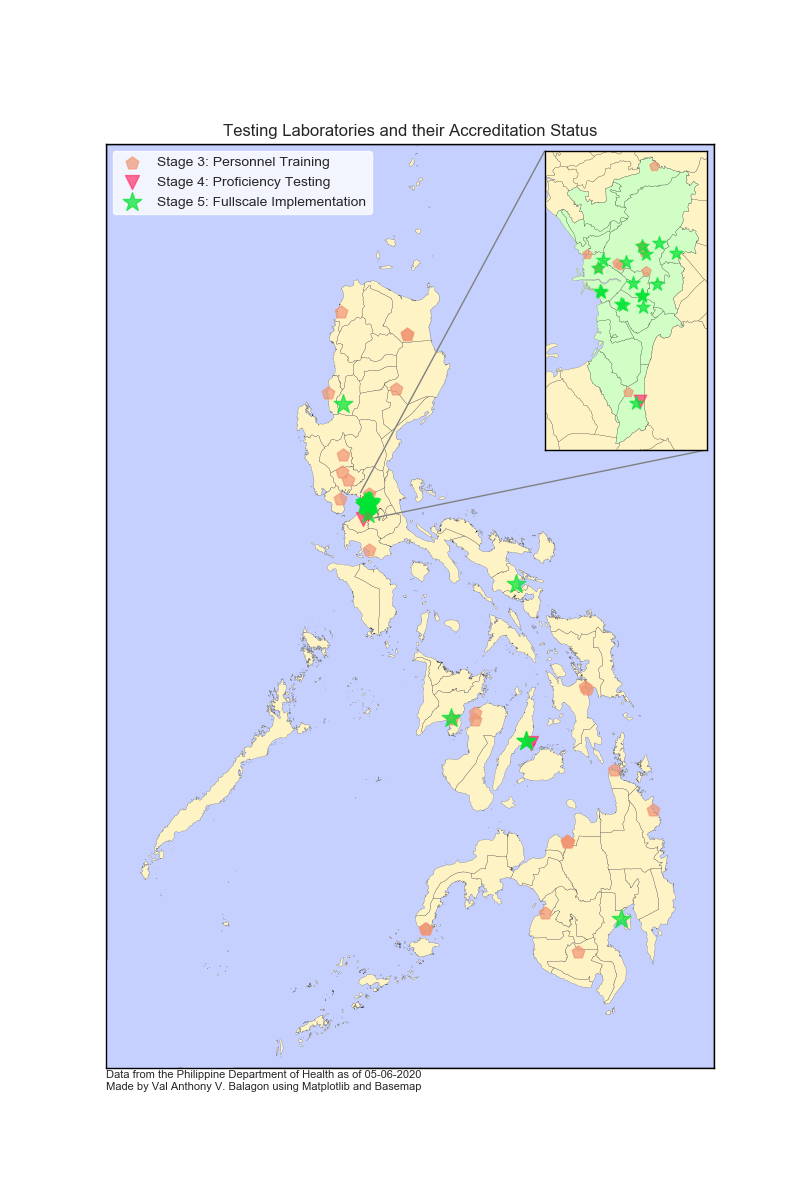

C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\tonba

In [199]:
import matplotlib

fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)

reso = 'l'
plt.title('Testing Laboratories and their Accreditation Status')
m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.3, urcrnrlat=21.1, resolution=reso, 
            lat_0 = 14, lon_0 = 120, ax=ax) 

# Make sure that the lakes do not get filled
m.drawmapboundary(fill_color='#c5d0fe')
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = False)


# Color each province
ls_provs = np.unique([ m.shf_info[i]['NAME_1'] for i in range(0, len(m.shf_info))])
patches=[]
for info, shape in zip(m.shf_info, m.shf):
    for i in ls_provs:
        if info['NAME_1'] == i:
            patches.append( Polygon(np.array(shape), True) )
ax.add_collection(PatchCollection(patches, 
                                  facecolor='#FEF3C5', linewidths=0.1, zorder=2))
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = True)


# Conversion of lats longs wrt to the projection
def testing_scatter(map_, axis_, n, marker, label, size, color):
    lats = [i[0] for i in df_testing_sites[df_testing_sites.stage == n].coordinates]
    longs = [i[1] for i in df_testing_sites[df_testing_sites.stage == n].coordinates]
    xpt, ypt = map_(longs, lats)
    return axis_.scatter(xpt, ypt, c=color, zorder=10, marker=marker, alpha=.7, s=size, label=label)

# testing_scatter(m, ax, 1, '.', 'Stage 1', 90, color='#ffa41b')
# testing_scatter(m, ax, 2, 'x', 'Stage 2', 90, color='#400082')

testing_scatter(m, ax, 3, 'p', 'Stage 3: Personnel Training', 90, color='#f09675')
testing_scatter(m, ax, 4, 'v', 'Stage 4: Proficiency Testing', 100, color='#fe346e')
testing_scatter(m, ax, 5, '*', 'Stage 5: Fullscale Implementation', 200, color='#01e432')
leg = ax.legend(loc=2, frameon=True)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')


# Map inset of Metro Manila
axins = zoomed_inset_axes(m.ax, 12, loc=1)#bbox_to_anchor=(700,1020)
m2 = Basemap(llcrnrlon=120.9, llcrnrlat=14.34, urcrnrlon=121.145, urcrnrlat=14.79, 
             resolution=reso, lat_0 = 14.34, lon_0 = 121, ax=axins) 
# Make sure that the lakes do not get filled
m2.drawmapboundary(fill_color='#c5d0fe')
m2.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = False)


# Color the shapefile
ls_provs = np.unique([ m.shf_info[i]['NAME_1'] for i in range(0, len(m.shf_info))])
patches=[]
for info, shape in zip(m.shf_info, m.shf):
    for i in ls_provs:
        if info['NAME_1'] == i:
            patches.append( Polygon(np.array(shape), True) )
axins.add_collection(PatchCollection(patches, 
                                  facecolor='#FEF3C5', linewidths=0.1, zorder=2))

# Highlight Manila
patches = []
for info, shape in zip(m2.shf_info, m2.shf):
    if info['NAME_1'] == 'Metropolitan Manila':
        patches.append(Polygon(np.array(shape), True))        
axins.add_collection(PatchCollection(patches, facecolor='#d0fec5', linewidths=0.1, zorder=2))

# Drawing the shapefile
m2.readshapefile('Shapefiles/gadm36_PHL_2',
                'shf', linewidth=0.1, drawbounds = True)

# Plotting
# testing_scatter(m2, axins, 1, '.', 'Stage 1', 50, color='#ffa41b')#Self-Assessment
# testing_scatter(m2, axins, 2, 'x', 'Stage 2', 50, color='#400082')#Validation
testing_scatter(m2, axins, 3, 'p', 'Stage 3', 50, color='#f09675')#
testing_scatter(m2, axins, 4, 'v', 'Stage 4', 80, color='#fe346e')#
testing_scatter(m2, axins, 5, '*', 'Stage 5', 100, color='#01e432')#

m.fillcontinents(color='#c5d0fe', lake_color='#c5d0fe')
m2.fillcontinents(color='#c5d0fe', lake_color='#c5d0fe')

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.text(116.3, 4, 'Data from the Philippine Department of Health as of {}\nMade by Val Anthony V. Balagon using Matplotlib and Basemap'.format(time_stamp), fontsize=8)
fig.savefig('images/locs_of_testing_sites', dpi=800, bbox_inches='tight')

### Folium Interactive

In [205]:
m = folium.Map(location=[np.mean([i[0] for i in df_testing_sites.coordinates]), np.mean([i[1] for i in df_testing_sites.coordinates])], 
               tiles='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png',
               attr="Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL.", 
               zoom_start=5.4)

# tiles='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
# attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>', 


mc = MarkerCluster()

def mapper(stage,color,icon='default'):
    # Getting the coordinates of each facility
    coords = [i for i in df_testing_sites[df_testing_sites.stage==stage].copy().coordinates]
    
    # Name of each facility with its status
    facilities = [i for i in np.array(df_testing_sites[df_testing_sites.stage==stage].copy().old_name)]
    classification = [i for i in np.array(df_testing_sites[df_testing_sites.stage==stage].copy().classification)]
    #np.array(df_testing_sites[df_testing_sites.stage==stage].copy().health_facility)
    for coord, facility, classes in zip(coords, np.array(facilities), np.array(classification)):
        folium.Marker(coord, radius=6, popup=folium.Popup(facility + r'<br>Stage: {}<br>Capability: {}'.format(stage, classes), 
                     encoding = 'latin-1',
                     max_height=100, min_height=100, 
                     max_width=300,min_width=130), 
                      icon=folium.Icon(color=color,icon=icon)).add_to(mc)

# # Stage 1
# mapper(1, 'orange')

# # Stage 2
# mapper(2, 'blue')

# Stage 3
mapper(3, 'purple')

# Stage 4
mapper(4, 'green')

# Stage 5
mapper(5, 'red', 'star')


# Legend

m.add_child(mc)
m

In [206]:
m.save('images/labs.html')

# Comparison with other countries

# Archived

<IPython.core.display.Javascript object>


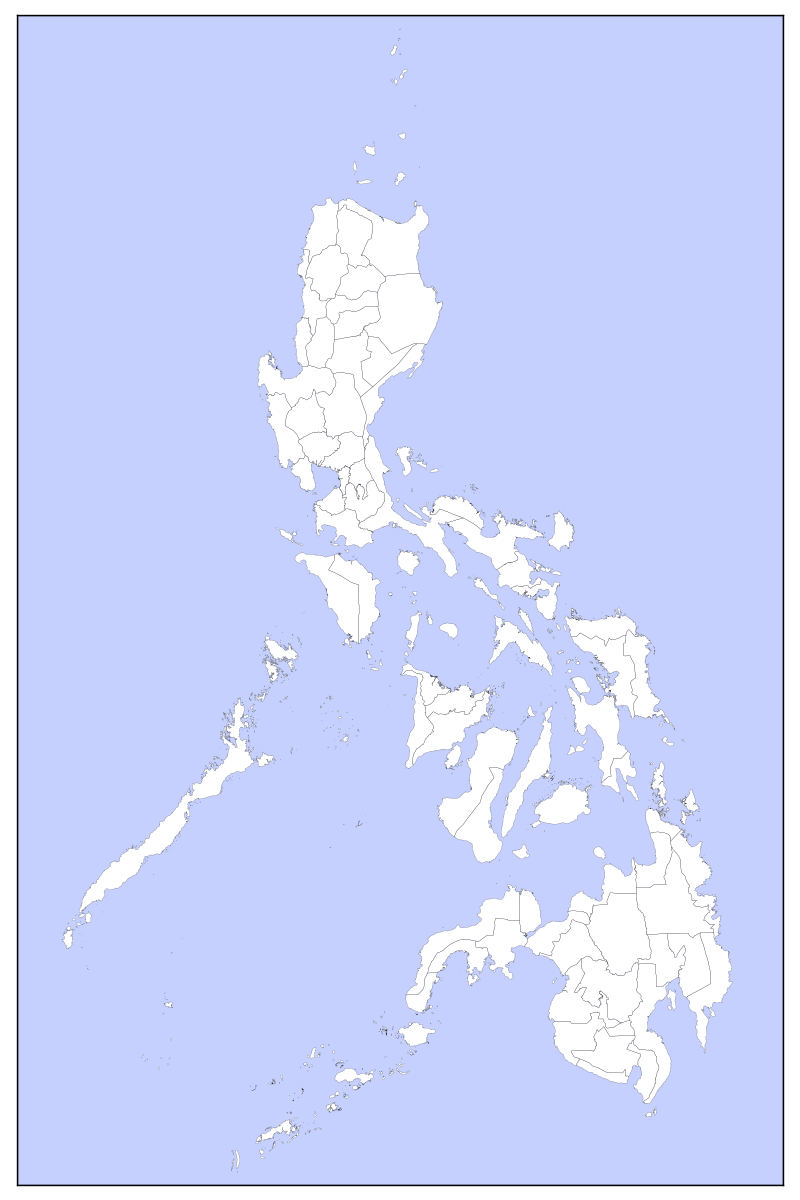

C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and 

In [123]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.8, urcrnrlat=21.1, resolution='l',
                projection='tmerc', lat_0 = 14, lon_0 = 120) 
# Reading the shapefile
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = False)

# Make sure that the lakes do not get filled
m.drawmapboundary(fill_color='#c5d0fe')
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = False)


# Color each province
ls_provs = np.unique([ m.shf_info[i]['NAME_1'] for i in range(0, len(m.shf_info))])
patches=[]
for info, shape in zip(m.shf_info, m.shf):
    for i in ls_provs:
        if info['NAME_1'] == i:
            patches.append( Polygon(np.array(shape), True) )
ax.add_collection(PatchCollection(patches, 
                                  facecolor='white', linewidths=0.1, zorder=2))
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = True)
fig.tight_layout()

In [ ]:
# fig, ax = plt.subplots(figsize=(8,12))

# if num_TBA_city == 0:
#     plt.title('Locations with Confirmed COVID19 Cases')
# if num_TBA_city > 0:
#     plt.title('Locations with Confirmed COVID19 Cases ({} for validation)'.format(num_TBA_city))

# qual = 'f'
# m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.3, urcrnrlat=21.1, resolution=qual, 
#             lat_0 = 14, lon_0 = 120) #, projection='tmerc' 

# m.drawmapboundary(fill_color='#c5d0fe')
# m.fillcontinents(color='#FEF3C5', lake_color='#c5d0fe')
# m.drawcoastlines(linewidth=0.1)
# m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = True)

# # Scatter Plot
# x,y = m(longs, lats)
# ax.scatter(x,y, c='red', edgecolors='red', alpha=.3, s=df_locs.counts * 4, zorder=10)

# # Table
# left, bottom, width, height = [0.16, 0.73, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.set_title('Cities and Municipalities\nwith the Most Cases', fontsize=10,x=0.215, y=.97)

# ## Making the table
# top_10_cities_ls = np.array((df_locs.com_address[:10]))[np.newaxis].T
# top_10_cities_count = np.array((df_locs.counts[:10]))[np.newaxis].T
# table = ax2.table(cellText=np.hstack((top_10_cities_ls, top_10_cities_count)),
#                   colWidths = [0.2]*100,
#                   loc='upper right',
#                   fontsize=10,
#                   cellLoc='left',
#                   edges='closed')
# table.auto_set_column_width(col=list(range(len(df_locs))))
# ax2.axis("off")
# ax2.axis('tight')


# # Map inset of Metro Manila
# axins = zoomed_inset_axes(ax, 12, loc=1)
# m2 = Basemap(llcrnrlon=120.9, llcrnrlat=14.34, urcrnrlon=121.145, urcrnrlat=14.79, 
#              resolution=qual, lat_0 = 14.34, lon_0 = 121, ax=axins) 
# m.drawmapboundary(fill_color='#c5d0fe')
# m.fillcontinents(color='#FEF3C5', lake_color='#c5d0fe')
# m.drawcoastlines(linewidth=0.1)
# m2.readshapefile('Shapefiles/gadm36_PHL_2', 'shf', linewidth=0.1,  drawbounds=False)

# # Highlight Manila
# patches = []
# for info, shape in zip(m2.shf_info, m2.shf):
#     if info['NAME_1'] == 'Metropolitan Manila':
#         patches.append(Polygon(np.array(shape), True))        
# axins.add_collection(PatchCollection(patches, facecolor='#d0fec5', linewidths=0.1, zorder=2))
# m2.readshapefile('Shapefiles/gadm36_PHL_2', 'shf', linewidth=0.1,  drawbounds=True)

# x_ins, y_ins = m(longs, lats)
# axins.scatter(x_ins, y_ins, c='red', alpha=.3, s=df_locs.counts * 0.7, edgecolors='red', zorder=10)
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# fig.tight_layout()
# ax.text(116.3, 4, 'Data from the Department of Health as of {}\nMade by Val Anthony Balagon using Matplotlib and Basemap'.format(time_stamp), fontsize=8)

In [ ]:
# fig, ax = plt.subplots(figsize=(8,12))

# if num_prov_TBA == 0:
#     plt.title('Provinces with Confirmed COVID19 Cases')
# if num_prov_TBA > 0 :
#     plt.title('Provinces with Confirmed COVID19 Cases ({} for validation)'.format(num_prov_TBA))

# reso = 'l'
# m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.8, urcrnrlat=21.1, resolution=reso,
#                 projection='tmerc', lat_0 = 14, lon_0 = 120) 

# # Reading the shapefile
# m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = False)

# # Coloring the province
# def province_color(condition):
#     patches=[]
#     for info, shape in zip(m.shf_info, m.shf):
#         for i in list(df_regions[condition].Province):
#             if info['NAME_1'] == i:
#                 patches.append( Polygon(np.array(shape), True) )
#     return patches

# # 1-10
# ax.add_collection(PatchCollection(province_color((df_regions.counts<10) & (df_regions.counts>=1)), 
#                                   facecolor='#ffe4d3', linewidths=0.1, zorder=2))
# # 10-50
# ax.add_collection(PatchCollection(province_color((df_regions.counts<50) & (df_regions.counts>=10)), 
#                                   facecolor='#ffcbac', linewidths=0.1, zorder=2))
# # 50-200
# ax.add_collection(PatchCollection(province_color((df_regions.counts<200) & (df_regions.counts>=50)), 
#                                   facecolor='#ffa671', linewidths=0.1, zorder=2))
# # 200-500
# ax.add_collection(PatchCollection(province_color((df_regions.counts<500) & (df_regions.counts>=200)), 
#                                   facecolor='#ff8236', linewidths=0.1, zorder=2))
# # 500-1000
# ax.add_collection(PatchCollection(province_color((df_regions.counts<1000) & (df_regions.counts>=500)), 
#                                   facecolor='#db5200', linewidths=0.1, zorder=2))
# # greater than 1000
# ax.add_collection(PatchCollection(province_color((df_regions.counts>=1000)), 
#                                   facecolor='#ff2d0f', linewidths=0.1, zorder=2))

# # Legend
# more_1000 = mpatches.Patch(color='#ff2d0f', label=r'$\geq$ 1000')
# less_1000 = mpatches.Patch(color='#db5200', label=r'500-999')
# less_500 = mpatches.Patch(color='#ff8236', label=r'200-499')
# less_200 = mpatches.Patch(color='#ffa671', label=r'50-199')
# less_50 = mpatches.Patch(color='#ffcbac', label=r'10-49')
# less_10 = mpatches.Patch(color='#ffe4d3', label=r'1-9')
# leg = plt.legend(loc=2, handles=[less_10, less_50, less_200, less_500, less_1000, more_1000][::-1], frameon=True)
# frame = leg.get_frame()
# frame.set_facecolor('white')
# frame.set_edgecolor('white')


# # Make sure that the lakes do not get filled
# m.drawmapboundary(fill_color='#c5d0fe')
# m.fillcontinents(color='white', lake_color='#c5d0fe')
# m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = True)

# # Top provinces
# ## Making another axis to make an inset
# left, bottom, width, height = [0.72, 0.75, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.set_title('Provinces with the Most Cases', fontsize=10,x=0.52, y=.98)

# ## Making the table
# top_10_prov_ls = np.array((df_regions.Province[:10]))[np.newaxis].T
# top_10_prov_count = np.array((df_regions.counts[:10]))[np.newaxis].T
# table = ax2.table(cellText=np.hstack((top_10_prov_ls, top_10_prov_count)),
#                   colWidths = [0.2]*100,
#                   loc='upper right',
#                   fontsize=10,
#                   cellLoc='left',
#                   edges='closed')
# table.auto_set_column_width(col=list(range(len(df_regions))))
# ax2.axis("off")
# ax2.axis('tight')

# ax.text(0, -40000, 'Data from the Department of Health as of {}\nMade by Val Anthony Balagon using Matplotlib and Basemap'.format(time_stamp), fontsize=8)
# fig.tight_layout()

In [ ]:
# # From google sheets directly
# df = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
#                    '1rLAZH7wN9DkigkFD070gy5YbEPr-RPQaqPvnePrh31E' +
#                    '/export?gid=30186846&format=csv')
# df.head()

In [ ]:
# Reading the excel file

# excel = pd.ExcelFile('Raw Data/doh_data_drop_04-14-2020.xlsx')  
# df = pd.read_excel(excel, 'Case Information')
# df.head()

In [ ]:
# Removing the 16:00 in the date

# def remove_hr(date):
#     # not null
#     if pd.notnull(date):
#     # Makes variable into a text
#         txt = str(date)
#         return pd.to_datetime(txt.split()[0])
#     else:
#         date
        
# df.DateRepConf = df.DateRepConf.apply(remove_hr)
# df.DateRepRem = df.DateRepRem.apply(remove_hr)
# df.DateRecover = df.DateRecover.apply(remove_hr)
# df.DateDied = df.DateDied.apply(remove_hr)


# df.head()
# # with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
# #     display(df)

# Bing Maps

API key: AsCIIUyQuVTJ4Df_KgfhNFOzKq2G18CNh2pKyXuDIfD7BReMtoz9COVbWsqbi4Jh

In [ ]:
# df.ProvCityRes.replace(to_replace ="Mogpog", value ="Mogpog Health Center, Mogpog", inplace=True) 
# df.ProvCityRes.replace(to_replace ="Torrijos", value ="St. Ignatius of Loyola Church, Torrijos", inplace=True) 
# df.ProvCityRes.replace(to_replace ="Mahinog", value ="St. Michael Parish Church, Mahinog", inplace=True) 
# df.ProvCityRes.replace(to_replace ="Panglao", value ="Panglao plaza", inplace=True) 

In [ ]:
# # UP National Institute of Health -> UP Manila


# df_testing_sites.replace(to_replace ="Tarlac Provincial Lab", value ="Tarlac Provincial Hospital", inplace=True) 

# df_testing_sites.replace(to_replace ="New World Diagnostics", value ="New World Diagnostics Quezon City", inplace=True) 



# df_testing_sites.replace(to_replace ="Dr. Jorge P. Royeca City Hospital", value ="Dr. Jorge P. Royeca Hospital", inplace=True) 


# # St. Luke's Medical Center Global City



# df_testing_sites.replace(to_replace ="Laguna Provincial Hospital", 
#            value ="Laguna Medical Center", inplace=True) 

# # The Medical City

# # Molecular Diagnostics Laboratory -> High Pointe Medical Hub

# # Governor Celestino Gallares Memorial Medical Center -> Memorial Hospital
# df_testing_sites.replace(to_replace ="Governor Celestino Gallares Memorial Medical Center", 
#            value ="Governor Celestino Gallares Memorial Hospital", inplace=True) 

# # and Medical Center


# # Mariano Marcos Hospital and Medical Center


# # De La Salle Medical and Health Sciences Institute - Center for Tuberculosis Laboratory





# df_testing_sites.replace(to_replace ="Philippine Genome Center, UP Mindanao", 
#            value ="University of the Philippines Mindanao", inplace=True) 

# df_testing_sites.replace(to_replace ="San Pablo College and Medical Center", 
#            value ="San Pablo Colleges Medical Center", inplace=True) 

# df_testing_sites.replace(to_replace ="Kaiser Medical Center, Inc.", 
#            value ="Kaiser Medical Center, Philippines", inplace=True) 

# df_testing_sites.replace(to_replace ="Green City Medical Center", 
#            value ="GreenCity Medical Center", inplace=True) 

